In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torchsummary import summary
import time
import os
import copy
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from torch.utils.data import random_split
from torch.utils.data import Dataset
import torch.backends.cudnn as cudnn
from livelossplot import PlotLosses

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
print(os.listdir("."))
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

['complete-pokemon-image-dataset', 'Pokemon.ipynb', 'pokemon.pt', 'kaggle-one-shot-pokemon', '.ipynb_checkpoints', 'loss_curve.png', 'accuracy_curve.png']
PyTorch Version:  1.1.0
Torchvision Version:  0.3.0


In [2]:
# Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([
                                        transforms.Resize(size=224),
                                        transforms.RandomVerticalFlip(p=0.5),
                                        transforms.RandomHorizontalFlip(p=0.5),
#                                         transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
                                        transforms.RandomRotation(degrees=20),
                                        transforms.RandomResizedCrop(size=224),
#                                         transforms.CenterCrop(size=224),
                                        transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

In [3]:
img_dir='/home/tinyswish/Desktop/MachineLearning/Pokemon/complete-pokemon-image-dataset/'
dataset = datasets.ImageFolder(img_dir, transform=train_transforms)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# number of subprocesses to use for data loading
num_workers = 4
# percentage of training set to use as validation
valid_size = int(0.2 * len(dataset))
test_size = int(0.1 * len(dataset))
train_size = len(dataset) - test_size - valid_size

train_dataset, test_dataset, valid_dataset = random_split(dataset, [train_size, test_size, valid_size])

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_dataset.dataset, batch_size=128, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(test_dataset.dataset, batch_size=128, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(valid_dataset.dataset, batch_size=64, num_workers=num_workers, shuffle=True)

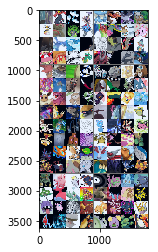

In [5]:
# functions to show an image
def imshow(img):
    img -= img.min()
    img /= img.max()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

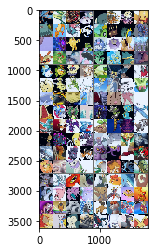

In [6]:
# get some random training images
dataiter = iter(valid_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [7]:
model = models.resnet152(pretrained=True)
    
fc_inputs = model.fc.in_features
 
model.fc = nn.Sequential(
    nn.Linear(fc_inputs, 1024),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1024, len(train_dataset.dataset.classes))
)
    
for name, child in model.named_children():
    if name in ['layer4', 'fc', 'avgpool']:
        print(name + ' is unfrozen')
        for param in child.parameters():
            param.requires_grad = True
    else:
        print(name + ' is frozen')
        for param in child.parameters():
            param.requires_grad = False
            
model

conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is frozen
layer4 is unfrozen
avgpool is unfrozen
fc is unfrozen


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [8]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()
    model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count())).to(device)
    cudnn.benchmark = True
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-5, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    

In [9]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


In [10]:
def train(n_epochs, model, optimizer, criterion, scheduler):
    """returns trained model"""
    liveloss = PlotLosses()
    # initialize tracker for minimum validation loss
    best_loss = np.Inf
    
    for epoch in range(n_epochs):
        logs = {}
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for batch_idx, (inputs, labels) in enumerate(train_loader if phase =='train' else valid_loader):
                inputs = inputs.cuda()
                labels = labels.cuda()

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len((train_loader if phase =='train' else valid_loader).dataset)
            epoch_acc = running_corrects.float() / len((train_loader if phase =='train' else valid_loader).dataset)
            
            acc1, acc3 = accuracy(outputs, labels, topk=(1, 3))
            print('Top 1 Accuracy: {:.4f} \tTop 3 Accuracy: {:.4f}'.format(acc1.item(), acc3.item()))
            
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
        
            if epoch_loss.item() <= best_loss:
                # Save if the model has best accuracy till now
                torch.save(model, 'pokemon.pt')
        
        scheduler.step()
        
        liveloss.update(logs)
        liveloss.draw()

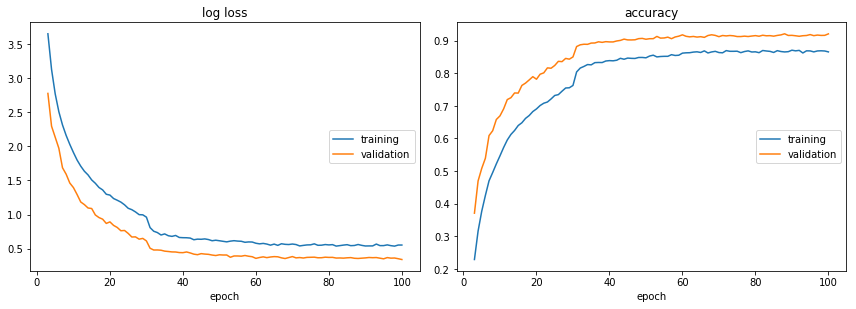

log loss:
training   (min:    0.538, max:    6.014, cur:    0.553)
validation (min:    0.341, max:    4.866, cur:    0.341)

accuracy:
training   (min:    0.030, max:    0.871, cur:    0.866)
validation (min:    0.086, max:    0.921, cur:    0.921)


In [11]:
train(100, model, optimizer, criterion, exp_lr_scheduler)

In [26]:
def computeTestSetAccuracy(model, loss_criterion):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    test_acc = 0.0
    test_loss = 0.0
    correct_counts = 0

    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts += torch.sum(predictions == labels.data)

            # Compute total accuracy in the whole batch and add to valid_acc
    test_acc = correct_counts.float() / len(test_loader.dataset)

    print("Test accuracy : " + str(test_acc.item()))

In [27]:
computeTestSetAccuracy(model, criterion)

Test accuracy : tensor(0.9143, device='cuda:0')


In [18]:
idx_to_class = {v: k for k, v in train_dataset.dataset.class_to_idx.items()}
def predict(model):
    total=0
    correct=0
    
    for batch_idx, (inputs, labels) in enumerate(test_loader):
 
        inputs = inputs.to(device)
     
        with torch.no_grad():
            model.eval()
            # Model outputs log probabilities
            out = model(inputs)
            ps = torch.exp(out)
            topk, topclass = ps.topk(1, dim=1)
            for i in range(len(inputs)):
                predicted = topclass.cpu().data.numpy().T.tolist()[0][i]
                target = labels.cpu().data.numpy().T.tolist()[i]
                print("Output class: {}\tTrue class: {}".format(
                    idx_to_class[predicted],idx_to_class[target]))
                total+=1
                if predicted == target: 
                    correct+=1
                    
    print('\nTotal: {} \tCorrect: {}'.format(total, correct))

In [19]:
predict(model)

Output class: Braixen	True class: Braixen
Output class: Wingull	True class: Wingull
Output class: Marshadow	True class: Marshadow
Output class: Sentret	True class: Sentret
Output class: Munchlax	True class: Munchlax
Output class: Tapu_Fini	True class: Tapu_Fini
Output class: Ninjask	True class: Ninjask
Output class: Tropius	True class: Tropius
Output class: Sigilyph	True class: Sigilyph
Output class: Dewpider	True class: Dewpider
Output class: Vanillite	True class: Vanillite
Output class: Blastoise(Mega)	True class: Blastoise(Mega)
Output class: Vanillish	True class: Vanillish
Output class: Crustle	True class: Crustle
Output class: Scatterbug	True class: Scatterbug
Output class: Latias(Mega)	True class: Latias(Mega)
Output class: Magmar	True class: Magmar
Output class: Darmanitan(Zen)	True class: Darmanitan(Zen)
Output class: Hitmonlee	True class: Hitmonlee
Output class: Kirlia	True class: Kirlia
Output class: Pumpkaboo	True class: Pumpkaboo
Output class: Hariyama	True class: Hariyama
